In [40]:
import pandas as pd
import numpy as np
import csv
import os
from scipy import stats
#import pyphysio as ph
from pdb import set_trace
import random
from datetime import timedelta, datetime
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

In [41]:
#survey windows 
#these are available in the 10 Minute Windows subfolder
surv = pd.read_csv('PR/PR023/PR023 Survey Windows MERGED.csv',parse_dates=['timestamp'], infer_datetime_format=True, index_col=[0])
surv['timestamp'] = pd.to_datetime(surv['timestamp'], format='mixed') #pandas deprecated the infer_datetime_format argument for read_csv, this is our workaround

#baseline windows
#also available in the 10 Minute Windows subfolder
base = pd.read_csv('PR/PR023/PR023 Baseline MERGED.csv',parse_dates=['timestamp'], infer_datetime_format=True, index_col=[0])

#ema responses
#found in Sofie Data subfolder, may have to dig for it 
ema = pd.read_csv('PR/PR023/PR023_rawwithtime2022-07-01.csv', parse_dates=['ethica_time_utc'], infer_datetime_format=True, index_col=[0])
ema['ethica_time_utc'] = pd.to_datetime(ema['ethica_time_utc']) #same workaround


In [42]:
#surv
surv2 = surv.groupby(['event']).apply(min)
with pd.option_context('display.max_rows', None,):
    print(surv2['timestamp'])



event
0    2021-01-31 18:02:00.000
3    2021-01-30 14:42:00.000
4    2021-01-29 23:15:00.000
5    2021-01-29 21:47:00.000
6    2021-01-29 16:59:00.000
13   2021-01-26 19:33:00.000
14   2021-01-26 16:04:00.000
15   2021-01-25 21:26:00.000
23   2021-01-23 02:24:00.000
24   2021-01-22 20:43:00.000
25   2021-01-22 18:59:00.000
34   2021-01-19 21:44:15.250
35   2021-01-19 18:55:00.000
36   2021-01-19 14:48:00.000
41   2021-01-17 23:18:00.000
42   2021-01-17 22:18:00.000
43   2021-01-17 17:50:00.000
44   2021-01-17 14:35:00.000
45   2021-01-17 02:56:00.000
46   2021-01-16 21:04:00.000
47   2021-01-16 18:31:00.000
48   2021-01-16 16:27:00.000
61   2021-01-12 17:49:00.000
62   2021-01-12 16:44:00.000
63   2021-01-12 01:37:00.000
64   2021-01-11 21:21:00.000
65   2021-01-11 19:01:00.000
66   2021-01-11 16:22:00.000
80   2021-01-07 02:49:00.000
81   2021-01-06 20:52:00.000
82   2021-01-06 17:18:00.000
83   2021-01-06 16:16:00.000
84   2021-01-06 00:52:00.000
85   2021-01-05 20:49:00.000
86   202

In [43]:
with pd.option_context('display.max_rows', None,):
    print(ema['ethica_time_utc'])


ID
PR023   2021-01-01 15:37:08
PR023   2021-01-01 17:33:00
PR023   2021-01-01 21:32:41
PR023   2021-01-02 01:18:30
PR023   2021-01-02 16:20:43
PR023   2021-01-02 17:51:33
PR023   2021-01-02 22:14:16
PR023   2021-01-03 02:04:41
PR023   2021-01-03 15:30:37
PR023   2021-01-03 17:00:37
PR023   2021-01-03 22:16:24
PR023   2021-01-04 00:44:32
PR023   2021-01-04 16:34:03
PR023   2021-01-04 18:33:51
PR023   2021-01-04 21:18:16
PR023   2021-01-05 01:21:30
PR023   2021-01-05 15:19:36
PR023   2021-01-05 19:33:13
PR023   2021-01-05 21:02:28
PR023   2021-01-06 01:09:10
PR023   2021-01-06 16:29:39
PR023   2021-01-06 17:37:23
PR023   2021-01-06 21:05:28
PR023   2021-01-07 03:05:36
PR023   2021-01-07 16:25:47
PR023   2021-01-07 18:40:33
PR023   2021-01-07 23:04:05
PR023   2021-01-08 00:17:27
PR023   2021-01-08 15:20:53
PR023   2021-01-08 18:33:00
PR023   2021-01-08 21:12:14
PR023   2021-01-09 03:30:22
PR023   2021-01-09 15:11:29
PR023   2021-01-09 19:48:06
PR023   2021-01-09 22:53:39
PR023   2021-01-0

In [44]:
### these scripts are taken from prior scripts written by collaborators with some modification by me
### these are all the functions we need... i think

#Preprocessing filters that will be applied to raw data samples
def exp_moving_average(signal, w):
    """Expoential moving average filter from pandas"""
    return pd.Series(signal.ewm(span=w, adjust=True).mean(), signal.index)

def filt_EDA(df_data):
    """Apply filter to EDA signal using processing steps from Pyphysio.
    
    Parameters
    ----------
    df_data : pandas.DataFrame
        DataFrame with EDA time and signal data
    
    Returns
    -------
    pandas.DataFrame 
        Updated DataFrame with Tonic and Phasic signals
    
    """
    
    # Set up Pyphysio EvenlySignal object
    eda_data = ph.EvenlySignal(values = df_data['EDA'].to_numpy(), sampling_freq = 4, signal_type='EDA')
    
    # Apply IIR filter
    eda_data = ph.IIRFilter(fp=0.8, fs=1.1, ftype='ellip')(eda_data)
    driver = ph.DriverEstim()(eda_data)
    
    # Estimate Tonic and Phasic signals
    phasic, tonic, _ = ph.PhasicEstim(delta=0.02)(driver)
    
    # Adjust signal length to match length of original EDA signal
    if len(phasic) != len(eda_data.get_values()):
        phasic = np.append(phasic.get_values(), phasic[-1])
        tonic = np.append(tonic.get_values(), tonic[-1])    
    
    # Append signal data to DataFrame
    df_data.loc[:,'Tonic'] = tonic
    df_data.loc[:,'Phasic'] = phasic
    return df_data  

def filt_TEMP(df_data):
    """Apply filter to TEMP signal using predetermined values"""
    df_data['TEMP_Filtered'] = exp_moving_average(df_data['TEMP'],60)
    return df_data

def filter_signals(df_data):
    """Apply filters/processing to respective signals.
    
    This function is intended to be used in conjunction with the
    pandas.DataFrame.apply() method, which passes a column of a DataFrame at
    a time.
    
    Parameters
    ----------
    df_data : pandas.Series
        A Series of DataFrames which contain all the signals for a single
        session.
    
    Returns
    -------
    pandas.Series
        Updated Series of DataFrames containing filtered/processed signal
        data
        
    Notes
    -----
    No filtering/processing for ACC, HR, and IBI signals is implemented,
    but is commented out for implementation in the future.
    
    """
    
    #df_data.loc['BVP'].loc[:,'BVP'] = filt_BVP(df_data.loc['BVP'])
    df_data = filt_EDA(df_data)
    df_data = filt_TEMP(df_data)
    
    return df_data


#RMS calculation Helper Function
def rms(data):
    return np.sqrt(np.mean(data ** 2))

#pandas deprecated the MAD function, so i went on stackoverflow and found a new one

def what_is_mad(list_of_nums):
    count = len(list_of_nums)
    mean = sum(list_of_nums) / count
    mad = sum((abs(num - mean) for num in list_of_nums)) / count
    return mad

#Every other feature is easy to calculate using Python built-ins
def feature_extract(df_data):
    result = {}
    result['Time'] = df_data.loc[:,'timestamp'].min()
    #for featbase in ['HR','EDA','TEMP','Tonic','Phasic','TEMP_Filtered']:
    for featbase in ['HR','EDA','TEMP', 'meanCenteredEDA', 'meanCenteredHR', 'meanCenteredTEMP']:
        #set_trace()
        result[featbase + '_Mean'] = df_data.loc[:,featbase].mean()
        result[featbase + '_Minimum'] = df_data.loc[:,featbase].min()
        result[featbase + '_Maximum'] = df_data.loc[:,featbase].max()
        result[featbase + '_Stdev'] = df_data.loc[:,featbase].std()
        result[featbase + '_RMS'] = rms(df_data.loc[:,featbase])
        result[featbase + '_MAD'] = what_is_mad(df_data.loc[:,featbase])
        result[featbase + '_MAV'] = df_data.loc[:,featbase].abs().max()
        result[featbase + '_Median'] = df_data.loc[:,featbase].median()
        result[featbase + '_P25'] = df_data.loc[:,featbase].quantile(0.25)
        result[featbase + '_P75'] = df_data.loc[:,featbase].quantile(0.75)
    return pd.Series(result, dtype='object')


#simplified the feature extraction function to only grab mean and median
def average_calc(df_data):
    result = {}    
    result['EDA_Mean'] = df_data.loc[:,'EDA'].mean()
    result['EDA_Median'] = df_data.loc[:,'EDA'].median()
    result['HR_Mean'] = df_data.loc[:,'HR'].mean()
    result['HR_Median'] = df_data.loc[:,'HR'].median()
    result['TEMP_Mean'] = df_data.loc[:,'TEMP'].mean()
    result['TEMP_Median'] = df_data.loc[:,'TEMP'].median()

    return pd.Series(result, dtype='object')

#creating a function to match rows
#remember that the physio timestamp must ALWAYS BE BEFORE the EMA timestamp

def windowMatch(features,surveys): 
    matchlist = []
    for index, frow in features.iterrows():
        physiotime = frow['Time']
        for index, srow in surveys.iterrows():
            ematime = srow['ethica_time_utc']
            #df3 = physiotime - ematime #physiotime and ematime can only be within 1 hour of each other - choose which one you're using here based on whichever gives you more matches, for some reason trying to use the absolute value breaks the code
            df3 = ematime - physiotime
            if df3 < delta and df3 > zeropoint:
                print("Physio time (", physiotime, ") and EMA time (", ematime, ") difference is", df3)
                matchlist.append(pd.concat([frow,srow],axis=0))
    return pd.DataFrame(matchlist)

In [45]:
#this chunk of code will normalize our date (deducting the average/median of the baseline windows from each datapoint in survey windows)

baseline_values = base.groupby(['code']).apply(average_calc) # calculating averages of the baseline

#creating variables to subtract from the dataframe columns
edamean = baseline_values.at[0,"EDA_Mean"]
edamed = baseline_values.at[0,"EDA_Median"]
hrmean = baseline_values.at[0,"HR_Mean"]
hrmed = baseline_values.at[0,"HR_Median"]
tempmean = baseline_values.at[0,"TEMP_Mean"]
tempmed = baseline_values.at[0,"TEMP_Median"]

#subtracting our means/medians from each value in the participant's data - excluding ACC 
surv['meanCenteredEDA'] = surv['EDA'] - edamean
surv['medianCenteredEDA'] = surv['EDA'] - edamed
surv['meanCenteredHR'] = surv['HR'] - hrmean
surv['medianCenteredHR'] = surv['HR'] - hrmed
surv['meanCenteredTEMP'] = surv['TEMP'] - tempmean
surv['medianCenteredTEMP'] = surv['TEMP'] - tempmed

surv.head()

,timestamp,HR,X,Y,Z,TEMP,BVP,EDA,event,meanCenteredEDA,medianCenteredEDA,meanCenteredHR,medianCenteredHR,meanCenteredTEMP,medianCenteredTEMP
timer,,,,,,,,,,,,,,,
0.25,2021-01-03 22:03:00.000,83.67,-54.0,-37.0,3.0,32.25,-227.63,0.016648,92,-0.061659,-0.064081,7.737334,10.79,-2.125801,-2.58
0.50,2021-01-03 22:03:00.250,83.80,-46.0,-40.0,1.0,32.25,-50.50,0.017929,92,-0.060378,-0.062800,7.867334,10.92,-2.125801,-2.58
0.75,2021-01-03 22:03:00.500,83.80,-50.0,-40.0,-3.0,32.25,-63.85,0.015368,92,-0.062939,-0.065361,7.867334,10.92,-2.125801,-2.58
1.00,2021-01-03 22:03:00.750,83.80,-51.0,-39.0,-2.0,32.25,-36.97,0.016648,92,-0.061659,-0.064081,7.867334,10.92,-2.125801,-2.58
1.25,2021-01-03 22:03:01.000,83.80,-52.0,-38.0,-3.0,32.25,3.98,0.015368,92,-0.062939,-0.065361,7.867334,10.92,-2.125801,-2.58


In [46]:
excl_list = ['ethica_time','lag','tdif','cumsumT','ethica_time_utc','dayvar','beepvar','beepconsec']
emafeat=[ele for ele in list(ema.columns) if ele not in excl_list]
for feat in emafeat:
    ema[feat+'_Mean'] = ema[feat]-ema[feat].mean()
    ema[feat+'_Median'] = ema[feat]-ema[feat].median()

C:\Users\AKarem\AppData\Local\Temp\ipykernel_20924\2707910219.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ema[feat+'_Mean'] = ema[feat]-ema[feat].mean()
C:\Users\AKarem\AppData\Local\Temp\ipykernel_20924\2707910219.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ema[feat+'_Median'] = ema[feat]-ema[feat].median()
C:\Users\AKarem\AppData\Local\Temp\ipykernel_20924\2707910219.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

In [48]:
#this chunk is to prepare the physio data to be matched to timestamps 

physio = surv.sort_values(['timestamp'], ignore_index=True) #sort by timestamp
physio = physio.groupby(['event']).apply(feature_extract) #applying feature extraction to create summary features

#setting up a timedelta to base our window matching off of
#a survey window can never occur more than an hour from when a survey was completed, so our delta is 1 hour
#if a window is more than an hour separate from survey completion, it cannot be matched
#however, the survey window timestamp should ALWAYS precede the survey completion time
delta = timedelta(hours = 1)
zeropoint = timedelta(seconds = 1)

#now we apply the window matching function - it calculates the time differences of each timestamp
#if the time difference is less than 10 minutes, 
mydf = windowMatch(physio, ema)
for index,row in mydf.iterrows():
    print (abs(row['ethica_time_utc']-row['Time']))
    
mydf.head()

Physio time ( 2021-01-31 18:02:00 ) and EMA time ( 2021-01-31 18:20:42 ) difference is 0 days 00:18:42
Physio time ( 2021-01-30 14:42:00 ) and EMA time ( 2021-01-30 14:55:18 ) difference is 0 days 00:13:18
Physio time ( 2021-01-29 23:15:00 ) and EMA time ( 2021-01-29 23:34:51 ) difference is 0 days 00:19:51
Physio time ( 2021-01-29 21:47:00 ) and EMA time ( 2021-01-29 22:00:37 ) difference is 0 days 00:13:37
Physio time ( 2021-01-29 16:59:00 ) and EMA time ( 2021-01-29 17:12:16 ) difference is 0 days 00:13:16
Physio time ( 2021-01-26 19:33:00 ) and EMA time ( 2021-01-26 19:43:14 ) difference is 0 days 00:10:14
Physio time ( 2021-01-26 19:33:00 ) and EMA time ( 2021-01-26 19:46:21 ) difference is 0 days 00:13:21
Physio time ( 2021-01-26 16:04:00 ) and EMA time ( 2021-01-26 16:17:30 ) difference is 0 days 00:13:30
Physio time ( 2021-01-25 21:26:00 ) and EMA time ( 2021-01-25 21:49:29 ) difference is 0 days 00:23:29
Physio time ( 2021-01-23 02:24:00 ) and EMA time ( 2021-01-23 02:42:11 ) 

,Time,HR_Mean,HR_Minimum,HR_Maximum,HR_Stdev,HR_RMS,HR_MAD,HR_MAV,HR_Median,HR_P25,HR_P75,EDA_Mean,EDA_Minimum,EDA_Maximum,EDA_Stdev,EDA_RMS,EDA_MAD,EDA_MAV,EDA_Median,EDA_P25,EDA_P75,TEMP_Mean,TEMP_Minimum,TEMP_Maximum,TEMP_Stdev,TEMP_RMS,TEMP_MAD,TEMP_MAV,TEMP_Median,TEMP_P25,TEMP_P75,meanCenteredEDA_Mean,meanCenteredEDA_Minimum,meanCenteredEDA_Maximum,meanCenteredEDA_Stdev,meanCenteredEDA_RMS,meanCenteredEDA_MAD,meanCenteredEDA_MAV,meanCenteredEDA_Median,meanCenteredEDA_P25,meanCenteredEDA_P75,meanCenteredHR_Mean,meanCenteredHR_Minimum,meanCenteredHR_Maximum,meanCenteredHR_Stdev,meanCenteredHR_RMS,meanCenteredHR_MAD,meanCenteredHR_MAV,meanCenteredHR_Median,meanCenteredHR_P25,meanCenteredHR_P75,meanCenteredTEMP_Mean,meanCenteredTEMP_Minimum,meanCenteredTEMP_Maximum,meanCenteredTEMP_Stdev,meanCenteredTEMP_RMS,meanCenteredTEMP_MAD,meanCenteredTEMP_MAV,meanCenteredTEMP_Median,meanCenteredTEMP_P25,meanCenteredTEMP_P75,ethica_time,lag,tdif,cumsumT,ethica_time_utc,dayvar,beepvar,beepconsec,sleep,fowg,wtshdiss,badperson,eat_public,eat_worry,anxiety,worthless,restrict,desirethin,overvalwtsh,reject,mistakes,highstand,iuc,saa,intrus_thought,fearloc,bodydiss,ineffective,food_intrus,guilty,shame,sad,si,thought_death,scared,feelfat,tired,agitated,relax,urge_restrict,stress,skipmeal,foodrules,vomit,laxdiur,binge,bodycheck,impulse,exercise,compulsion,avoid_food,selfharm,hunger_anx,smallportion,drink_public,avoid_emo,avoid_sit,emo_overwhelm,eat_anx,rumination,heartrace,physsens_eat,attn_others,worryoverwhelm,physsens,socialanx,sens_body,ridthoughts,memories,chewspit,sleep_Mean,sleep_Median,fowg_Mean,fowg_Median,wtshdiss_Mean,wtshdiss_Median,badperson_Mean,badperson_Median,eat_public_Mean,eat_public_Median,eat_worry_Mean,eat_worry_Median,anxiety_Mean,anxiety_Median,worthless_Mean,worthless_Median,restrict_Mean,restrict_Median,desirethin_Mean,desirethin_Median,overvalwtsh_Mean,overvalwtsh_Median,reject_Mean,reject_Median,mistakes_Mean,mistakes_Median,highstand_Mean,highstand_Median,iuc_Mean,iuc_Median,saa_Mean,saa_Median,intrus_thought_Mean,intrus_thought_Median,fearloc_Mean,fearloc_Median,bodydiss_Mean,bodydiss_Median,ineffective_Mean,ineffective_Median,food_intrus_Mean,food_intrus_Median,guilty_Mean,guilty_Median,shame_Mean,shame_Median,sad_Mean,sad_Median,si_Mean,si_Median,thought_death_Mean,thought_death_Median,scared_Mean,scared_Median,feelfat_Mean,feelfat_Median,tired_Mean,tired_Median,agitated_Mean,agitated_Median,relax_Mean,relax_Median,urge_restrict_Mean,urge_restrict_Median,stress_Mean,stress_Median,skipmeal_Mean,skipmeal_Median,foodrules_Mean,foodrules_Median,vomit_Mean,vomit_Median,laxdiur_Mean,laxdiur_Median,binge_Mean,binge_Median,bodycheck_Mean,bodycheck_Median,impulse_Mean,impulse_Median,exercise_Mean,exercise_Median,compulsion_Mean,compulsion_Median,avoid_food_Mean,avoid_food_Median,selfharm_Mean,selfharm_Median,hunger_anx_Mean,hunger_anx_Median,smallportion_Mean,smallportion_Median,drink_public_Mean,drink_public_Median,avoid_emo_Mean,avoid_emo_Median,avoid_sit_Mean,avoid_sit_Median,emo_overwhelm_Mean,emo_overwhelm_Median,eat_anx_Mean,eat_anx_Median,rumination_Mean,rumination_Median,heartrace_Mean,heartrace_Median,physsens_eat_Mean,physsens_eat_Median,attn_others_Mean,attn_others_Median,worryoverwhelm_Mean,worryoverwhelm_Median,physsens_Mean,physsens_Median,socialanx_Mean,socialanx_Median,sens_body_Mean,sens_body_Median,ridthoughts_Mean,ridthoughts_Median,memories_Mean,memories_Median,chewspit_Mean,chewspit_Median
0,2021-01-31 18:02:00,92.951544,73.42,146.43,18.632728,94.799911,12.724978,146.43,87.58,81.70,91.95,0.056773,0.017940,0.094824,0.015267,0.058789,0.011390,0.094824,0.057663,0.049975,0.066633,32.190033,31.73,32.59,0.200531,32.190658,0.153892,32.59,32.21,32.11,32.31,-0.021534,-0.060367,0.016517,0.015267,0.026395,0.011390,0.060367,-0.020644,-0.028332,-0.011674,17.018878,-2.512666,70.497334,18.632728,25.232438,12.724978,70.497334,11.647334,5.767334,16.017334,-2.185767,-2.645801,-1.785801,0.200531,2.194943,0.153892,2.6458

In [49]:
#putting together physio featureset to be ready for correlations
featbase =['HR','EDA','TEMP', 'meanCenteredEDA', 'meanCenteredHR', 'meanCenteredTEMP']
featstat =['_Mean','_Minimum','_Stdev','_RMS','_MAD','_MAV','_Median','_P25','_P75']
physio_feats = {}
allfeats = []
for fb in featbase:
    curfeats=[]
    for fs in featstat:
        curfeats.append(fb+fs)
        allfeats.append(fb+fs)
    physio_feats[fb] = mydf[curfeats]
physio_feats['All'] = mydf[allfeats]
        

In [50]:
pd.set_option('display.max_columns', None)
list(mydf.columns)

['Time',
 'HR_Mean',
 'HR_Minimum',
 'HR_Maximum',
 'HR_Stdev',
 'HR_RMS',
 'HR_MAD',
 'HR_MAV',
 'HR_Median',
 'HR_P25',
 'HR_P75',
 'EDA_Mean',
 'EDA_Minimum',
 'EDA_Maximum',
 'EDA_Stdev',
 'EDA_RMS',
 'EDA_MAD',
 'EDA_MAV',
 'EDA_Median',
 'EDA_P25',
 'EDA_P75',
 'TEMP_Mean',
 'TEMP_Minimum',
 'TEMP_Maximum',
 'TEMP_Stdev',
 'TEMP_RMS',
 'TEMP_MAD',
 'TEMP_MAV',
 'TEMP_Median',
 'TEMP_P25',
 'TEMP_P75',
 'meanCenteredEDA_Mean',
 'meanCenteredEDA_Minimum',
 'meanCenteredEDA_Maximum',
 'meanCenteredEDA_Stdev',
 'meanCenteredEDA_RMS',
 'meanCenteredEDA_MAD',
 'meanCenteredEDA_MAV',
 'meanCenteredEDA_Median',
 'meanCenteredEDA_P25',
 'meanCenteredEDA_P75',
 'meanCenteredHR_Mean',
 'meanCenteredHR_Minimum',
 'meanCenteredHR_Maximum',
 'meanCenteredHR_Stdev',
 'meanCenteredHR_RMS',
 'meanCenteredHR_MAD',
 'meanCenteredHR_MAV',
 'meanCenteredHR_Median',
 'meanCenteredHR_P25',
 'meanCenteredHR_P75',
 'meanCenteredTEMP_Mean',
 'meanCenteredTEMP_Minimum',
 'meanCenteredTEMP_Maximum',
 'meanC

In [52]:
#cleaning up EMA dataset for correlations
excl_list = ['ethica_time','lag','tdif','cumsumT','ethica_time_utc','dayvar','beepvar','beepconsec']
surfeat=[ele for ele in list(ema.columns) if ele not in excl_list]
ema_feats = mydf[surfeat]

In [53]:
ema_feats

,sleep,fowg,wtshdiss,badperson,eat_public,eat_worry,anxiety,worthless,restrict,desirethin,overvalwtsh,reject,mistakes,highstand,iuc,saa,intrus_thought,fearloc,bodydiss,ineffective,food_intrus,guilty,shame,sad,si,thought_death,scared,feelfat,tired,agitated,relax,urge_restrict,stress,skipmeal,foodrules,vomit,laxdiur,binge,bodycheck,impulse,exercise,compulsion,avoid_food,selfharm,hunger_anx,smallportion,drink_public,avoid_emo,avoid_sit,emo_overwhelm,eat_anx,rumination,heartrace,physsens_eat,attn_others,worryoverwhelm,physsens,socialanx,sens_body,ridthoughts,memories,chewspit,sleep_Mean,sleep_Median,fowg_Mean,fowg_Median,wtshdiss_Mean,wtshdiss_Median,badperson_Mean,badperson_Median,eat_public_Mean,eat_public_Median,eat_worry_Mean,eat_worry_Median,anxiety_Mean,anxiety_Median,worthless_Mean,worthless_Median,restrict_Mean,restrict_Median,desirethin_Mean,desirethin_Median,overvalwtsh_Mean,overvalwtsh_Median,reject_Mean,reject_Median,mistakes_Mean,mistakes_Median,highstand_Mean,highstand_Median,iuc_Mean,iuc_Median,saa_Mean,saa_Median,intrus_thought_Mean,intrus_thought_Median,fearloc_Mean,fearloc_Median,bodydiss_Mean,bodydiss_Median,ineffective_Mean,ineffective_Median,food_intrus_Mean,food_intrus_Median,guilty_Mean,guilty_Median,shame_Mean,shame_Median,sad_Mean,sad_Median,si_Mean,si_Median,thought_death_Mean,thought_death_Median,scared_Mean,scared_Median,feelfat_Mean,feelfat_Median,tired_Mean,tired_Median,agitated_Mean,agitated_Median,relax_Mean,relax_Median,urge_restrict_Mean,urge_restrict_Median,stress_Mean,stress_Median,skipmeal_Mean,skipmeal_Median,foodrules_Mean,foodrules_Median,vomit_Mean,vomit_Median,laxdiur_Mean,laxdiur_Median,binge_Mean,binge_Median,bodycheck_Mean,bodycheck_Median,impulse_Mean,impulse_Median,exercise_Mean,exercise_Median,compulsion_Mean,compulsion_Median,avoid_food_Mean,avoid_food_Median,selfharm_Mean,selfharm_Median,hunger_anx_Mean,hunger_anx_Median,smallportion_Mean,smallportion_Median,drink_public_Mean,drink_public_Median,avoid_emo_Mean,avoid_emo_Median,avoid_sit_Mean,avoid_sit_Median,emo_overwhelm_Mean,emo_overwhelm_Median,eat_anx_Mean,eat_anx_Median,rumination_Mean,rumination_Median,heartrace_Mean,heartrace_Median,physsens_eat_Mean,physsens_eat_Median,attn_others_Mean,attn_others_Median,worryoverwhelm_Mean,worryoverwhelm_Median,physsens_Mean,physsens_Median,socialanx_Mean,socialanx_Median,sens_body_Mean,sens_body_Median,ridthoughts_Mean,ridthoughts_Median,memories_Mean,memories_Median,chewspit_Mean,chewspit_Median
0,42.0,9.0,18.0,20.0,2.0,1.0,17.0,10.0,0.0,17.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,33.0,32.0,46.0,24.0,31.0,2.0,0.0,0.0,0.0,23.0,27.0,32.0,24.0,37.0,12.0,20.0,20.0,68.0,0.0,61.0,35.0,0.0,21.0,0.0,22.0,0.0,19.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,19.0,41.0,1.0,2.0,38.0,6.0,49.0,0.0,0.0,0.0,-6.038095,-10.0,-10.83,-10.0,-4.99,-4.0,2.96,8.5,0.35,2.0,-35.39,-32.0,-2.1,2.0,0.26,6.0,-45.17,-51.0,-16.48,-12.0,8.71,10.5,-0.52,0.0,-7.92,0.0,-1.73,0.0,-3.02,0.0,-0.98,0.0,-3.06,0.0,-10.76,-8.0,10.49,14.0,-4.05,0.0,-2.69,-8.0,-1.05,4.0,13.61,16.0,-4.5,2.0,-0.12,0.0,-1.94,0.0,-1.32,0.0,3.46,6.5,-21.434343,-21.0,13.454545,20.0,-5.1,0.5,-11.0,-17.0,-17.33,-15.5,-33.8,-42.0,-16.11,-21.5,37.01,68.0,0.0,0.0,33.2,59.0,0.77,2.5,-10.53,0.0,-22.88,-27.0,-0.55,0.0,0.74,12.5,-0.04,0.0,-21.22,-32.0,-14.75,0.0,-0.04,0.0,-4.87,0.0,-1.27,0.0,-1.87,0.0,-19.61,-17.0,-1.57,0.0,1.51,13.0,7.0,9.0,-5.616162,1.0,-14.857143,-13.0,6.44898,11.5,-3.43299,1.0,18.479167,21.5,-0.773196,0.0,-0.742268,0.0,-3.072165,0.0
1,57.0,20.0,29.0,10.0,0.0,25.0,1.0,0.0,52.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0,19.0,13.0,54.0,8.0,24.0,5.0,0.0,0.0,0.0,0.0,12.0,2.0,19.0,68.0,2.0,69.0,61.0,0.0,0.0,0.0,41.0,0.0,51.0,0.0,53.0,0.0,37.0,17.0,0.0,0.0,0.0,0.0,15.0,0.0,6.0,19.0,0.0,5.0,7.0,0.0,45.0,0.0,0.0,0.0,8.961905,5.0,0.17,1.0,6.01,7.0,-7.04,-1.5,-1.65,0.0,-11.39,-8.0,-18.1,-14.0,-9.74,-4.0,6.83,1.0,-19.48,-15.0,-3.29,-1.5,-0.52,0.0,-7.92,0.0,-1.73,0.0,-3.02,0.0,-0.98,0.0,-3.06,0.0,-4.76,-2.0,-3.51,0.0,-23.05,-19.0,5.31,0.0,-17.05,-12.0,6.61,9.0,-1.5,5.0,-0.12,0.0

In [54]:
#now we're correlating physio with EMA here
corrdict = {}
for sur in surfeat:
    corrdict[sur]=physio_feats['All'].corrwith(ema_feats[sur],method='pearson')
    corrdict[sur]=physio_feats['All'].corrwith(ema_feats[sur],method='pearson')
corr_df = pd.DataFrame(corrdict)
                                                     
corr_df

,sleep,fowg,wtshdiss,badperson,eat_public,eat_worry,anxiety,worthless,restrict,desirethin,overvalwtsh,reject,mistakes,highstand,iuc,saa,intrus_thought,fearloc,bodydiss,ineffective,food_intrus,guilty,shame,sad,si,thought_death,scared,feelfat,tired,agitated,relax,urge_restrict,stress,skipmeal,foodrules,vomit,laxdiur,binge,bodycheck,impulse,exercise,compulsion,avoid_food,selfharm,hunger_anx,smallportion,drink_public,avoid_emo,avoid_sit,emo_overwhelm,eat_anx,rumination,heartrace,physsens_eat,attn_others,worryoverwhelm,physsens,socialanx,sens_body,ridthoughts,memories,chewspit,sleep_Mean,sleep_Median,fowg_Mean,fowg_Median,wtshdiss_Mean,wtshdiss_Median,badperson_Mean,badperson_Median,eat_public_Mean,eat_public_Median,eat_worry_Mean,eat_worry_Median,anxiety_Mean,anxiety_Median,worthless_Mean,worthless_Median,restrict_Mean,restrict_Median,desirethin_Mean,desirethin_Median,overvalwtsh_Mean,overvalwtsh_Median,reject_Mean,reject_Median,mistakes_Mean,mistakes_Median,highstand_Mean,highstand_Median,iuc_Mean,iuc_Median,saa_Mean,saa_Median,intrus_thought_Mean,intrus_thought_Median,fearloc_Mean,fearloc_Median,bodydiss_Mean,bodydiss_Median,ineffective_Mean,ineffective_Median,food_intrus_Mean,food_intrus_Median,guilty_Mean,guilty_Median,shame_Mean,shame_Median,sad_Mean,sad_Median,si_Mean,si_Median,thought_death_Mean,thought_death_Median,scared_Mean,scared_Median,feelfat_Mean,feelfat_Median,tired_Mean,tired_Median,agitated_Mean,agitated_Median,relax_Mean,relax_Median,urge_restrict_Mean,urge_restrict_Median,stress_Mean,stress_Median,skipmeal_Mean,skipmeal_Median,foodrules_Mean,foodrules_Median,vomit_Mean,vomit_Median,laxdiur_Mean,laxdiur_Median,binge_Mean,binge_Median,bodycheck_Mean,bodycheck_Median,impulse_Mean,impulse_Median,exercise_Mean,exercise_Median,compulsion_Mean,compulsion_Median,avoid_food_Mean,avoid_food_Median,selfharm_Mean,selfharm_Median,hunger_anx_Mean,hunger_anx_Median,smallportion_Mean,smallportion_Median,drink_public_Mean,drink_public_Median,avoid_emo_Mean,avoid_emo_Median,avoid_sit_Mean,avoid_sit_Median,emo_overwhelm_Mean,emo_overwhelm_Median,eat_anx_Mean,eat_anx_Median,rumination_Mean,rumination_Median,heartrace_Mean,heartrace_Median,physsens_eat_Mean,physsens_eat_Median,attn_others_Mean,attn_others_Median,worryoverwhelm_Mean,worryoverwhelm_Median,physsens_Mean,physsens_Median,socialanx_Mean,socialanx_Median,sens_body_Mean,sens_body_Median,ridthoughts_Mean,ridthoughts_Median,memories_Mean,memories_Median,chewspit_Mean,chewspit_Median
HR_Mean,0.245376,-0.114839,-0.200649,-0.078989,0.160918,-0.123613,0.199893,-0.059475,-0.176562,-0.229335,0.010550,0.025051,-0.338614,-0.224420,0.079725,0.084983,-0.045215,-0.105134,0.085084,-0.025634,0.051492,-0.107491,-0.043697,-0.092438,NaN,-0.079002,0.210201,-0.067260,-0.090078,0.181511,0.217331,-0.246073,0.085201,-0.207307,-0.211824,0.350982,NaN,0.384758,0.043936,0.398029,-0.015806,0.213845,-0.258007,NaN,-0.230553,-0.181581,-0.064436,-0.155840,-0.081782,0.050265,-0.100059,0.157361,0.128494,0.202170,0.140152,0.041578,0.116757,0.008811,0.338690,0.067422,0.028626,-0.066433,0.245376,0.245376,-0.114839,-0.114839,-0.200649,-0.200649,-0.078989,-0.078989,0.160918,0.160918,-0.123613,-0.123613,0.199893,0.199893,-0.059475,-0.059475,-0.176562,-0.176562,-0.229335,-0.229335,0.010550,0.010550,0.025051,0.025051,-0.338614,-0.338614,-0.224420,-0.224420,0.079725,0.079725,0.084983,0.084983,-0.045215,-0.045215,-0.105134,-0.105134,0.085084,0.085084,-0.025634,-0.025634,0.051492,0.051492,-0.107491,-0.107491,-0.043697,-0.043697,-0.092438,-0.092438,-2.051408e-15,NaN,-0.079002,-0.079002,0.210201,0.210201,-0.067260,-0.067260,-0.090078,-0.090078,0.181511,0.181511,0.217331,0.217331,-0.246073,-0.246073,0.085201,0.085201,-0.207307,-0.207307,-0.211824,-0.211824,0.350982,0.350982,NaN,NaN,0.384758,0.384758,0.043936,0.043936,0.398029,0.398029,-0.015806,-0.015806,0.213845,0.213845,-0.258007,-0.258007,-2.051408e-15,NaN,-0.230553,-0.230553,-0.181581,-0.181581,-0.064436,-0.064436,-0.155840,-0.155840,-0.081782,-0.081782,0.050265,0.0

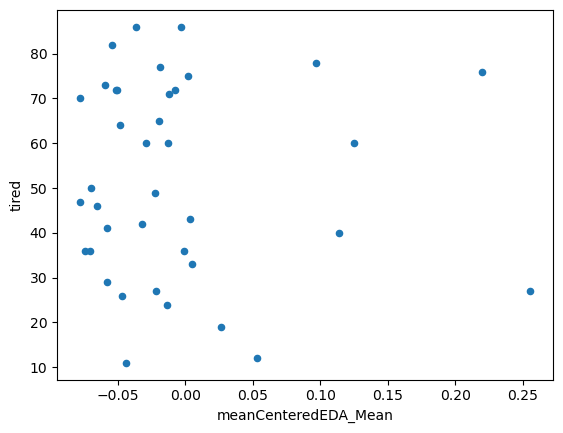

In [80]:
#just in case you want to do some scatterplots 
#you'll notice a lot of outliers in some of these plots - we may want to establish some way to remove outliers - perhaps if something is 4+ SDs from the mean?
#ax1= mydf.plot.scatter(x='meanCenteredHR_Mean',y='heartrace')
ax1= mydf.plot.scatter(x='meanCenteredEDA_Mean',y='tired')

In [71]:
mydf

,Time,HR_Mean,HR_Minimum,HR_Maximum,HR_Stdev,HR_RMS,HR_MAD,HR_MAV,HR_Median,HR_P25,HR_P75,EDA_Mean,EDA_Minimum,EDA_Maximum,EDA_Stdev,EDA_RMS,EDA_MAD,EDA_MAV,EDA_Median,EDA_P25,EDA_P75,TEMP_Mean,TEMP_Minimum,TEMP_Maximum,TEMP_Stdev,TEMP_RMS,TEMP_MAD,TEMP_MAV,TEMP_Median,TEMP_P25,TEMP_P75,meanCenteredEDA_Mean,meanCenteredEDA_Minimum,meanCenteredEDA_Maximum,meanCenteredEDA_Stdev,meanCenteredEDA_RMS,meanCenteredEDA_MAD,meanCenteredEDA_MAV,meanCenteredEDA_Median,meanCenteredEDA_P25,meanCenteredEDA_P75,meanCenteredHR_Mean,meanCenteredHR_Minimum,meanCenteredHR_Maximum,meanCenteredHR_Stdev,meanCenteredHR_RMS,meanCenteredHR_MAD,meanCenteredHR_MAV,meanCenteredHR_Median,meanCenteredHR_P25,meanCenteredHR_P75,meanCenteredTEMP_Mean,meanCenteredTEMP_Minimum,meanCenteredTEMP_Maximum,meanCenteredTEMP_Stdev,meanCenteredTEMP_RMS,meanCenteredTEMP_MAD,meanCenteredTEMP_MAV,meanCenteredTEMP_Median,meanCenteredTEMP_P25,meanCenteredTEMP_P75,ethica_time,lag,tdif,cumsumT,ethica_time_utc,dayvar,beepvar,beepconsec,sleep,fowg,wtshdiss,badperson,eat_public,eat_worry,anxiety,worthless,restrict,desirethin,overvalwtsh,reject,mistakes,highstand,iuc,saa,intrus_thought,fearloc,bodydiss,ineffective,food_intrus,guilty,shame,sad,si,thought_death,scared,feelfat,tired,agitated,relax,urge_restrict,stress,skipmeal,foodrules,vomit,laxdiur,binge,bodycheck,impulse,exercise,compulsion,avoid_food,selfharm,hunger_anx,smallportion,drink_public,avoid_emo,avoid_sit,emo_overwhelm,eat_anx,rumination,heartrace,physsens_eat,attn_others,worryoverwhelm,physsens,socialanx,sens_body,ridthoughts,memories,chewspit,sleep_Mean,sleep_Median,fowg_Mean,fowg_Median,wtshdiss_Mean,wtshdiss_Median,badperson_Mean,badperson_Median,eat_public_Mean,eat_public_Median,eat_worry_Mean,eat_worry_Median,anxiety_Mean,anxiety_Median,worthless_Mean,worthless_Median,restrict_Mean,restrict_Median,desirethin_Mean,desirethin_Median,overvalwtsh_Mean,overvalwtsh_Median,reject_Mean,reject_Median,mistakes_Mean,mistakes_Median,highstand_Mean,highstand_Median,iuc_Mean,iuc_Median,saa_Mean,saa_Median,intrus_thought_Mean,intrus_thought_Median,fearloc_Mean,fearloc_Median,bodydiss_Mean,bodydiss_Median,ineffective_Mean,ineffective_Median,food_intrus_Mean,food_intrus_Median,guilty_Mean,guilty_Median,shame_Mean,shame_Median,sad_Mean,sad_Median,si_Mean,si_Median,thought_death_Mean,thought_death_Median,scared_Mean,scared_Median,feelfat_Mean,feelfat_Median,tired_Mean,tired_Median,agitated_Mean,agitated_Median,relax_Mean,relax_Median,urge_restrict_Mean,urge_restrict_Median,stress_Mean,stress_Median,skipmeal_Mean,skipmeal_Median,foodrules_Mean,foodrules_Median,vomit_Mean,vomit_Median,laxdiur_Mean,laxdiur_Median,binge_Mean,binge_Median,bodycheck_Mean,bodycheck_Median,impulse_Mean,impulse_Median,exercise_Mean,exercise_Median,compulsion_Mean,compulsion_Median,avoid_food_Mean,avoid_food_Median,selfharm_Mean,selfharm_Median,hunger_anx_Mean,hunger_anx_Median,smallportion_Mean,smallportion_Median,drink_public_Mean,drink_public_Median,avoid_emo_Mean,avoid_emo_Median,avoid_sit_Mean,avoid_sit_Median,emo_overwhelm_Mean,emo_overwhelm_Median,eat_anx_Mean,eat_anx_Median,rumination_Mean,rumination_Median,heartrace_Mean,heartrace_Median,physsens_eat_Mean,physsens_eat_Median,attn_others_Mean,attn_others_Median,worryoverwhelm_Mean,worryoverwhelm_Median,physsens_Mean,physsens_Median,socialanx_Mean,socialanx_Median,sens_body_Mean,sens_body_Median,ridthoughts_Mean,ridthoughts_Median,memories_Mean,memories_Median,chewspit_Mean,chewspit_Median
0,2021-01-31 18:02:00.000,92.951544,73.42,146.43,18.632728,94.799911,12.724978,146.43,87.58,81.70,91.95,0.056773,0.017940,0.094824,0.015267,0.058789,0.011390,0.094824,0.057663,0.049975,0.066633,32.190033,31.73,32.59,0.200531,32.190658,0.153892,32.59,32.21,32.11,32.31,-0.021534,-0.060367,0.016517,1.526734e-02,0.026395,1.139023e-02,0.060367,-0.020644,-0.028332,-0.011674,17.018878,-2.512666,70.497334,18.632728,25.232438,12.724978,70.497334,11.647334,5.767334,16.017334,-2.185767,-2.645801,-1.785801,0.200531,2.194943,0.1

In [17]:
#/Users/sandoval/Library/CloudStorage/Box-Box/R15 Sensor Preprocessing and Analysis/JPCS Special Issue/normalizing.ipynb

#this will save the centered survey windows
surv.to_csv('PR023 Survey Windows CENTERED.csv')

#this will save our correlation matrix 
corr_df.to_csv('PR023 Survey Correlations.csv')
mydf.to_csv()



In [16]:
physio_feats['All'].columns

Index(['HR_Mean', 'HR_Minimum', 'HR_Stdev', 'HR_RMS', 'HR_MAD', 'HR_MAV',
       'HR_Median', 'HR_P25', 'HR_P75', 'EDA_Mean', 'EDA_Minimum', 'EDA_Stdev',
       'EDA_RMS', 'EDA_MAD', 'EDA_MAV', 'EDA_Median', 'EDA_P25', 'EDA_P75',
       'TEMP_Mean', 'TEMP_Minimum', 'TEMP_Stdev', 'TEMP_RMS', 'TEMP_MAD',
       'TEMP_MAV', 'TEMP_Median', 'TEMP_P25', 'TEMP_P75',
       'meanCenteredEDA_Mean', 'meanCenteredEDA_Minimum',
       'meanCenteredEDA_Stdev', 'meanCenteredEDA_RMS', 'meanCenteredEDA_MAD',
       'meanCenteredEDA_MAV', 'meanCenteredEDA_Median', 'meanCenteredEDA_P25',
       'meanCenteredEDA_P75', 'meanCenteredHR_Mean', 'meanCenteredHR_Minimum',
       'meanCenteredHR_Stdev', 'meanCenteredHR_RMS', 'meanCenteredHR_MAD',
       'meanCenteredHR_MAV', 'meanCenteredHR_Median', 'meanCenteredHR_P25',
       'meanCenteredHR_P75', 'meanCenteredTEMP_Mean',
       'meanCenteredTEMP_Minimum', 'meanCenteredTEMP_Stdev',
       'meanCenteredTEMP_RMS', 'meanCenteredTEMP_MAD', 'meanCenteredTEMP_MAV',

In [78]:
tempmean

34.37580080566745

In [24]:
ema_feats['sleep']

0     42.0
1     57.0
2      NaN
3      NaN
4      NaN
5     39.0
6     39.0
7     39.0
8      NaN
9      NaN
10     NaN
11     NaN
12    26.0
13    26.0
14    26.0
15    58.0
16    58.0
17    58.0
18    58.0
19    70.0
20    70.0
21    70.0
22    70.0
23    64.0
24    64.0
25    21.0
26    21.0
27    21.0
28    21.0
29    34.0
30    34.0
31    34.0
32    34.0
33    29.0
34    29.0
35    29.0
36    29.0
37    55.0
38    55.0
Name: sleep, dtype: float64